#Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from random import randint
from itertools import permutations
import codecs
import itertools
import time

#Classes used

In [345]:
class traveling_salesman:

  def __init__(self,n,bounds,costs=None):

    self.n = n
    self.bounds = bounds
    if costs is None:
      self.create_costs() 
    else:
      if len(costs[0]) is n and len(costs) is n:
        self.costs = costs
      else:
        raise Exception('Verify if the cost size is correct in relation to the route passed through the parameters.')
    self.time_used = None
  
  def create_costs(self):

    costs = []

    for i in range(self.n):
      row = []
      for j in range(self.n):
        row.append(round(random.uniform(self.bounds[0],self.bounds[1]),2))
      
      costs.append(row)
    
    self.costs =  costs

  def hill_climbing(self,route):

      [all_routes,all_costs,improved,iteration] = [[],[],True,0]

      old_route = route.copy() if route is not None else self.generate_one_random_solution()
      old_cost = self.calculate_cost(old_route)
      new_route = old_route

      all_routes.append(old_route)
      all_costs.append(old_cost)
      start_time = time.time()

      while(improved):
        
        [new_route,new_cost] = self.swap_2_first(old_route,False) 
        
        if new_cost < old_cost:

          old_route = new_route.copy()
          old_cost = new_cost

          iteration+=1
        
        else:
          improved = False
      
      end_time = time.time()
      self.time_used = end_time - start_time

      return [old_route,old_cost,iteration]

  def brute_force(self):

    current_cost = float('inf')
    current_route = []

    for route in itertools.permutations(range(self.n)):
      
      route = route + (route[0],)  # Route is a tuple.

      new_cost = self.calculate_cost(route)

      if new_cost < current_cost:

        current_cost = new_cost
        current_route = route

    return [current_route,current_cost]

  def generate_one_random_solution(self):

    solution = [vertex for vertex in range(self.n)]
    solution = random.sample(solution,self.n)
    solution.append(solution[0])

    return solution

  def greedy(self, initial_vertice = None):

    solution = [initial_vertice if initial_vertice is not None else randint(0,self.n-1)]
    [available_nodes,current_node,new_cost] = [[i for i in range(0,self.n)],solution[0],0]

    available_nodes.remove(current_node)
    
    start_time = time.time()

    for i in range(0,self.n-1):

      available_node_costs = [self.costs[current_node][j] for j in available_nodes]
      
      next_node = available_nodes[available_node_costs.index(min(available_node_costs))]
      #numpy argmin
      solution.append(next_node)
      new_cost += self.costs[current_node][next_node]

      available_nodes.remove(next_node)
      current_node = next_node

    solution.append(solution[0])
    new_cost+=self.costs[next_node][solution[0]]
    
    end_time = time.time()
    self.time_used = end_time - start_time

    return solution,new_cost,None

  def calculate_cost(self,solution):
    
    sum = 0
    for i in range(1,len(solution)):

      sum += self.costs[solution[i-1]][solution[i]]
    
    return sum

  def swap_2_first(self,route = None,warning_condition=True):

    # Swap 2 vertices until finding a better solution. 
    solution = route.copy() if route is not None else self.generate_one_random_solution()

    current_cost = self.calculate_cost(solution)

    for i in range(self.n-1):

      for j in range(i+1,self.n):

        new_solution = solution.copy()
        
        aux = new_solution[j]
        new_solution[j] = new_solution[i] #swap
        new_solution[i] = aux

        new_solution[self.n] = new_solution[0]

        new_cost = self.calculate_cost(new_solution)
        
        if new_cost < current_cost:  
          solution = new_solution.copy()
          current_cost = new_cost

          return [solution,current_cost]
      
      if warning_condition: print('\n swap warning: Não foi encontrado nenhuma solução melhor, retornando o original\n')
      return [solution,current_cost]

  def vnd(self,route,delta,max_iteration):
    
    old_route = route.copy() if route is not None else self.generate_one_random_solution()
    old_cost = self.calculate_cost(old_route)
    counter = 0
    improvement = True
    all_cost = [old_cost]

    start_time = time.time()

    #while(improvement and counter<max_iteration):
    while(improvement):
      
      counter += 1
      [current_route,current_cost] = self.swap_2_first(old_route,False)

      if current_cost + delta < old_cost:
         old_cost = current_cost
         old_route = current_route.copy()
         
         all_cost.append(old_cost)
         continue
      else:
        improvement = False

      [current_route,current_cost] = self.opt_2(old_route)

      if current_cost + delta < old_cost:
        old_cost = current_cost
        old_route = current_route.copy()
        improvement = True

        all_cost.append(old_cost)

    end_time = time.time()
    self.time_used = end_time - start_time
    
    return [old_route,round(old_cost,3),counter]

  
  def opt_2(self,route):

    new_route = route.copy()
    node_number = len(route)
    new_costs = self.calculate_cost(route)
    costs =  self.costs

    for i in range(node_number-3):

      for j in range(i+2,node_number-1):

        if costs[route[i]][route[i+1]] + costs[route[j]][route[j+1]] > costs[route[i]][route[j]]+costs[route[i+1]][route[j+1]]:

          aux = route[j]
          route[j] = route[i+1]
          route[i+1] = aux

          new_costs = self.calculate_cost(route)
        
    return [route,new_costs]


  def opt_2_first(self,route,warning_condition=False):

      new_route = route.copy()
      node_number = len(route)
      new_costs = self.calculate_cost(route)
      costs =  self.costs

      for i in range(node_number-3):

        for j in range(i+2,node_number-1):

          if costs[route[i]][route[i+1]] + costs[route[j]][route[j+1]] > costs[route[i]][route[j]]+costs[route[i+1]][route[j+1]]:

            aux = route[j]
            route[j] = route[i+1]
            route[i+1] = aux

            new_costs = self.calculate_cost(route)

            return [route,new_costs]
      
      if warning_condition: print('Warning: Nenhum melhoramento encontrado')
          
      return [route,new_costs]

  def random_mult_start(self,route,max_iteration,delta):
    
    old_route = route.copy() if route is not None else self.generate_one_random_solution()
    old_cost = self.calculate_cost(old_route)
    count = 0

    start_time = time.time()

    for i in range(max_iteration):

      greedy_random_route = self.generate_one_random_solution()
      [new_route,new_cost,useless_variable] = self.vnd(greedy_random_route,delta,max_iteration)
      count+=1
      if new_cost < old_cost:

        old_route = new_route.copy()
        old_cost = new_cost
    
    end_time = time.time()
    self.time_used = end_time - start_time

    return old_route,old_cost,None

    
    return [better_solution, better_cost, None]

  def iterated_local_search(self,max_iteration): # I need to add the disturbance before the VND.

    [old_solution,old_cost,useless] = self.random_mult_start(1)
    [improvement,count] = [True,0]
    
    start_time = time.time()

    while improvement and count<max_iteration:
      vnd_results = self.vnd(old_solution,0.01,max_iteration)
      [current_solution,current_cost] = [vnd_results[0],vnd_results[1]]

      if current_cost < old_cost:
        
        old_solution = current_solution.copy()
        old_cost = current_cost
      else:
        improvement = False

      count+=1
    
    end_time = time.time()
    self.time_used = end_time - start_time

    return [old_solution,old_cost,count]

  def GRASP(self,k,max_iteration,route=None,delta=0.01):

    old_route = route.copy() if route is not None else self.generate_one_random_solution()
    old_cost = self.calculate_cost(old_route)
    count = 0
    
    start_time = time.time()

    for i in range(max_iteration):

      greedy_random_route = self.greedy_random(k)
      [new_route,new_cost,useless_variable] = self.vnd(greedy_random_route,delta,max_iteration)
      count+=1
      if new_cost < old_cost:

        old_route = new_route.copy()
        old_cost = new_cost
    
    end_time = time.time()
    self.time_used = end_time - start_time

    return old_route,old_cost,None

  def greedy_random(self,k,initial_vertice=None):

      solution = [initial_vertice if initial_vertice is not None else randint(0,self.n-1)]
      [available_nodes,current_node,new_cost] = [[i for i in range(0,self.n)],solution[0],0]

      available_nodes.remove(current_node)
      
      for i in range(0,self.n-1):

        available_node_costs = [self.costs[current_node][j] for j in available_nodes]
        
        sorted_available_node_costs = available_node_costs.copy()
        sorted_available_node_costs.sort()

        if len(sorted_available_node_costs) >= k:
          k_best_available_nodes_costs = [sorted_available_node_costs[best_cost] for best_cost in range(k)]
          # Drawing the elements from best_available_k_node_costs array based on the costs.
          inv_k_best_available_nodes_costs = [1/inv for inv in k_best_available_nodes_costs]  
          drawn_cost = random.choices(k_best_available_nodes_costs,weights=inv_k_best_available_nodes_costs,k=1)[0]
        else:
          drawn_cost = random.choices(sorted_available_node_costs,weights=sorted_available_node_costs,k=1)[0]
        
        next_node = available_nodes[available_node_costs.index(drawn_cost)]
        solution.append(next_node)
        available_nodes.remove(next_node)
        current_node = next_node

      solution.append(solution[0])

      return solution
  
  def performe_n_methods(self,methods,result_simulation,parameters,n_node):

    methods = [self.hill_climbing,self.random_mult_start,self.greedy,self.vnd,self.GRASP]

    for method in methods:

      method_name = method.__name__
      
      [route,cost,count] = method(*parameters[method_name])

      result_simulation[method_name]['node_number'].append(n_node)
      result_simulation[method_name]['cost'].append(cost)
      result_simulation[method_name]['time'].append(self.time_used)
      result_simulation[method_name]['iteration'].append(count)

    return result_simulation
  
      
def plot_vertices(route,xs,ys,node_number,line_cor = 'black',cost_text=None,cost_matrix=None,save_fig=False,name_fig='chooseMyName'):

  plt.figure(figsize=(10,6))
  ys = [ys[i] for i in route]
  xs = [xs[i] for i in route]
  plt.plot(xs,ys,line_cor)
  plt.plot(xs,ys,'ob')
  
  for i in range(node_number):
  
    plt.text(xs[i]-0.2,ys[i]+0.2,'Node '+str(route[i]))
  
  if cost_text is not None:
  
    for i in range(node_number):
      plt.text(cost_text[i][0],cost_text[i][1],str(cost_matrix[cost_text[i][2]][cost_text[i][3]]))
  
  if save_fig:
    plt.savefig(name_fig)
  plt.show()

def convex_combination_of_edges(route,xs,ys,alpha,node_number):

  if alpha>1 or alpha < 0: raise Exception('alpha inválido')

  edges = []
  #ys = [ys[i] for i in xs]
  for i in range(node_number):
    edges.append([alpha*xs[route[i]]+(1-alpha)*xs[route[i+1]],alpha*ys[route[i]]+(1-alpha)*ys[route[i+1]],route[i],route[i+1]])

  return edges

class performing_simulations:

  def __init__(self,travelling_salesman,methods,parameters,cost_bounds,k_bounds):

    self.travelling_salesman_v = travelling_salesman
    self.methods = methods
    self.cost_bounds = cost_bounds
    self.k_bounds = k_bounds
    self.parameters = parameters
  
  def creating_costs(self,node_number):
    xs = [randint(0,10*node_number) for x in range(node_number)]
    ys = [randint(0,10*node_number) for x in range(node_number)]
    
    xs.append(xs[0])
    ys.append(ys[0])

    calculate_distance = lambda x_dif,y_dif: (x_dif**2+y_dif**2)**(1/2)

    distances = []

    for i in range(node_number):
        row = []
        for j in range(node_number):
          if i is not j:
            row.append(round(calculate_distance(xs[i]-xs[j],ys[i]-ys[j]),4))
          else:
            row.append(float('inf'))
        
        distances.append(row)

    return xs,ys,distances

  def execute(self):

    available_methods = {1:'greedy',2:'hill_climbing',3:'vnd',5:'random_mult_start',6:'GRASP'}
    result_simulation = {value.__name__:{'node_number':[],'cost':[],'time':[],'iteration':[]} for key,value in enumerate(self.methods) if self.methods[key].__name__ in available_methods.values()}
    
    for k_nodes in range(self.k_bounds[0],self.k_bounds[1]):
      
      xs,ys,distances = self.creating_costs(k_nodes)
      model = self.travelling_salesman_v(k_nodes,self.cost_bounds,distances)
      initial_route = model.generate_one_random_solution()
      model.performe_n_methods(self.methods,result_simulation,self.parameters,k_nodes)

    return result_simulation



#Generating a random route and calculating the distance among all dots.

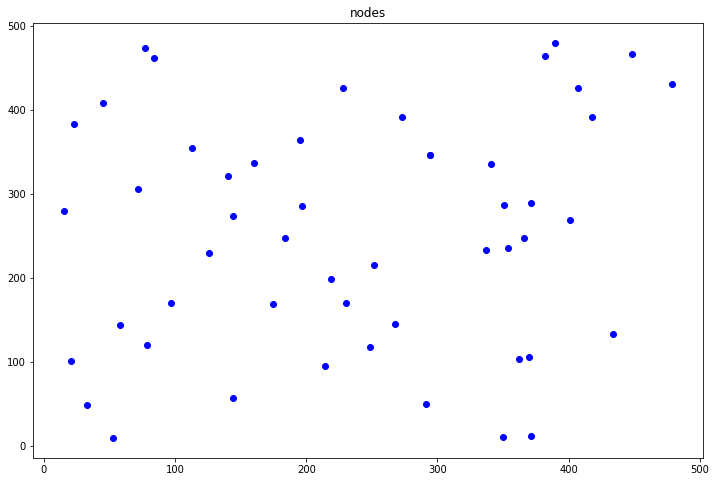

In [346]:
node_number = 50

xs = [randint(0,10*node_number) for x in range(node_number)]
ys = [randint(0,10*node_number) for x in range(node_number)]

xs.append(xs[0])
ys.append(ys[0])

calculate_distance = lambda x_dif,y_dif: (x_dif**2+y_dif**2)**(1/2)

distances = []

for i in range(node_number):
    row = []
    for j in range(node_number):
      if i is not j:
        row.append(round(calculate_distance(xs[i]-xs[j],ys[i]-ys[j]),4))
      else:
        row.append(float('inf'))
    
    distances.append(row)

plt.figure(figsize=(12,8))
plt.plot(xs,ys,'ob')
plt.title('nodes')
plt.show()


## Showing all costs and setting up the parameters.

A rota aleatoria gerada foi [14, 46, 23, 43, 5, 16, 12, 37, 33, 49, 9, 17, 38, 22, 42, 20, 36, 41, 44, 48, 15, 47, 29, 21, 4, 13, 0, 8, 32, 35, 28, 27, 6, 45, 31, 18, 1, 2, 3, 34, 39, 30, 26, 7, 24, 40, 25, 11, 10, 19, 14] e o seu custo é 12084.5807


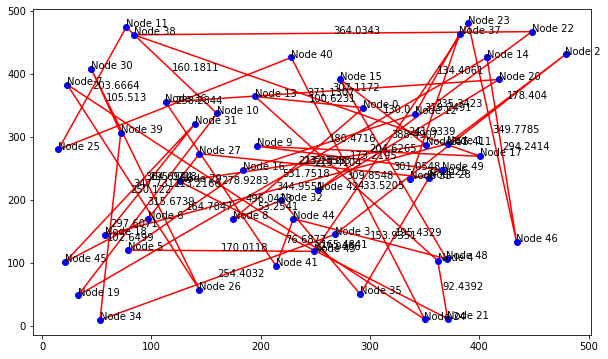

In [347]:
simulation = traveling_salesman(node_number,[10,300],distances)
initial_route = simulation.generate_one_random_solution()
#display(pd.DataFrame(simulation.costs))
print(f'A rota aleatoria gerada foi {initial_route} e o seu custo é {simulation.calculate_cost(initial_route)}')
time_random = None
cost_texts = convex_combination_of_edges(initial_route,xs,ys,0.5,node_number)
plot_vertices(initial_route,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs)



#heuristics

In [348]:
result_costs = [] # Append the costs of the generated routes by the algorithms to this array.
result_costs.append(simulation.calculate_cost(initial_route))
times = []
times.append(None)

##Greedy

A rota gerada pela seleção do melhor caminho foi [16, 9, 27, 29, 6, 18, 5, 45, 19, 34, 26, 41, 43, 3, 44, 32, 42, 33, 28, 49, 17, 1, 47, 12, 0, 15, 40, 13, 10, 31, 36, 39, 25, 7, 30, 38, 11, 37, 23, 14, 20, 2, 22, 46, 48, 4, 35, 24, 21, 8, 16] e o seu custo é 3226.96 e tbm deve ser 3226.9600999999993


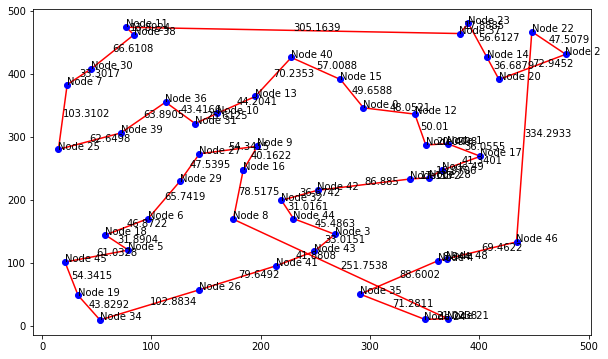

In [349]:
route_greedy,cost,count = simulation.greedy()
simulation.calculate_cost(route_greedy)

print(f'A rota gerada pela seleção do melhor caminho foi {route_greedy} e o seu custo é {round(simulation.calculate_cost(route_greedy),2)} e tbm deve ser {cost}')

cost_texts = convex_combination_of_edges(route_greedy,xs,ys,0.5,node_number)

plot_vertices(route_greedy,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs,save_fig=True,name_fig='greedy')

times.append(simulation.time_used)
result_costs.append(cost)


## Hill Climbing

A melhor rota por Hill Climbing com swap e 2 opt foi [34, 20, 2, 14, 22, 37, 23, 38, 7, 36, 13, 28, 48, 46, 24, 35, 43, 44, 42, 47, 12, 49, 33, 21, 4, 32, 16, 8, 41, 6, 18, 5, 29, 27, 31, 9, 1, 17, 3, 26, 39, 30, 45, 0, 15, 40, 25, 11, 10, 19, 34] e o seu custo é 6387.47 e tbm deve ser 6387.470099999999
Quantidade de iterações necessárias 99


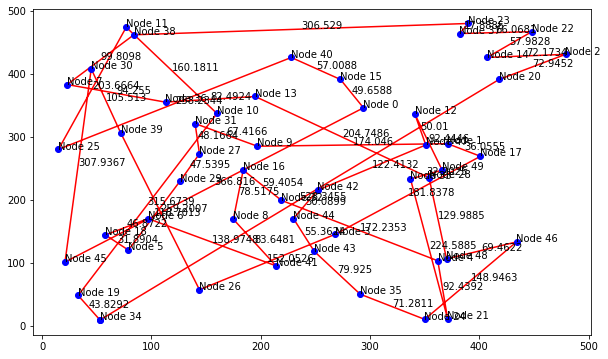

In [350]:

[hill_route,hill_cost,iterations] = simulation.hill_climbing(initial_route)

print(f'A melhor rota por Hill Climbing com swap e 2 opt foi {hill_route} e o seu custo é {round(simulation.calculate_cost(hill_route),2)} e tbm deve ser {hill_cost}')
print(f'Quantidade de iterações necessárias {iterations}')
cost_texts = convex_combination_of_edges(hill_route,xs,ys,0.5,node_number)

plot_vertices(hill_route,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs)

times.append(simulation.time_used)
result_costs.append(hill_cost)

##VND

[5, 45, 19, 34, 26, 41, 35, 24, 21, 46, 48, 4, 43, 3, 33, 28, 49, 17, 1, 47, 12, 20, 2, 22, 23, 37, 14, 15, 40, 38, 11, 30, 7, 39, 36, 10, 13, 0, 42, 44, 8, 32, 9, 31, 27, 16, 29, 25, 6, 18, 5] 3278.479 105 3278.4793


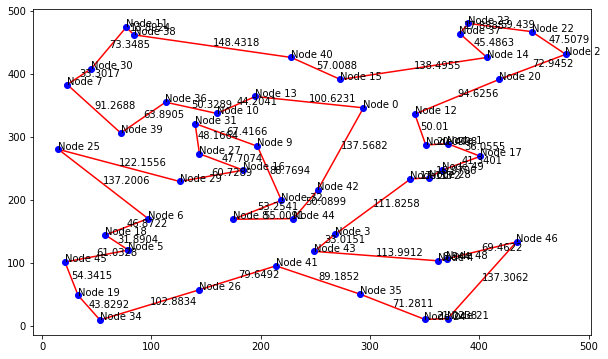

In [351]:
[vnd_route,vnd_cost,iterations] = simulation.vnd(initial_route,0.01,1000)

print(vnd_route,vnd_cost,iterations,simulation.calculate_cost(vnd_route))

cost_texts = convex_combination_of_edges(vnd_route,xs,ys,0.5,node_number)

plot_vertices(vnd_route,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs)

times.append(simulation.time_used)
result_costs.append(vnd_cost)

##Random multi Start

A melhor solução gerada pelo RMS foi [21, 24, 35, 41, 43, 3, 42, 32, 44, 8, 26, 34, 19, 45, 5, 18, 6, 29, 16, 9, 27, 39, 25, 7, 30, 11, 38, 36, 31, 10, 13, 40, 15, 37, 23, 22, 2, 14, 20, 12, 0, 47, 1, 17, 49, 28, 33, 46, 48, 4, 21] e o seu custo é de 2876.91 


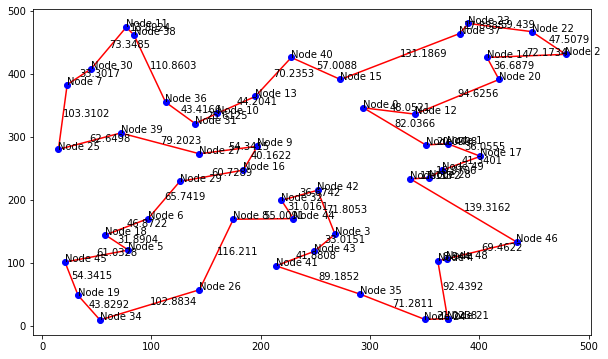

In [352]:
route_rms, cost, count = simulation.random_mult_start(initial_route,100,0.01)

print(f'A melhor solução gerada pelo RMS foi {route_rms} e o seu custo é de {round(cost,2)} ')

cost_texts = convex_combination_of_edges(route_rms,xs,ys,0.5,node_number)

plot_vertices(route_rms,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs)

times.append(simulation.time_used)
result_costs.append(cost)


##GRASP

A rota pelo Grasp foi [49, 28, 33, 46, 48, 4, 21, 24, 35, 3, 43, 41, 26, 34, 19, 45, 5, 18, 6, 8, 44, 32, 42, 16, 9, 27, 29, 39, 25, 7, 30, 11, 38, 36, 31, 10, 13, 40, 15, 0, 37, 23, 22, 2, 14, 20, 12, 47, 1, 17, 49] e o seu custo é 2851.77 e tbm deve ser 2851.771


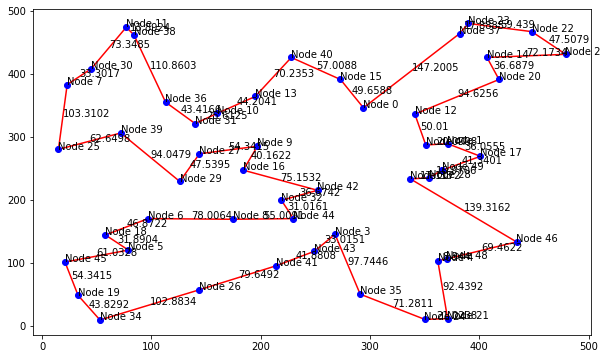

In [353]:
[grasp_route,grasp_cost,count] = simulation.GRASP(3,100,route=initial_route)

print(f'A rota pelo Grasp foi {grasp_route} e o seu custo é {round(simulation.calculate_cost(grasp_route),2)} e tbm deve ser {grasp_cost}')

cost_texts = convex_combination_of_edges(grasp_route,xs,ys,0.5,node_number)

plot_vertices(grasp_route,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs,save_fig=True,name_fig="grasp")

times.append(simulation.time_used)
result_costs.append(grasp_cost)


# Comparison of Results

In [354]:
df_result_costs = pd.DataFrame([result_costs,times],index=['Custo da rota','Tempo usado(seg.)'],columns=['Aleatória','Greedy','Hill Climbing','VND','Random Multi Start','Grasp']).T
display(df_result_costs)

,Custo da rota,Tempo usado(seg.)
Aleatória,12084.5807,NaN
Greedy,3226.9601,0.001121
Hill Climbing,6387.4701,0.029687
VND,3278.4790,0.037752
Random Multi Start,2876.9110,1.849698
Grasp,2851.7710,0.962434


In [357]:
parameters = {
    'random_mult_start':[None,100,0.01], # max_iteration
    'greedy':[None], # initial
    'GRASP':[3,100,None,0.01], #K, max_iteration, initial_route, delta
    'hill_climbing':[None], # initial_route
    'vnd':[None,0.01,100], # initial_route, delta, max_iteration
}

result_dic = performing_simulations(traveling_salesman,[traveling_salesman.vnd,traveling_salesman.greedy,traveling_salesman.hill_climbing,traveling_salesman.random_mult_start,traveling_salesman.GRASP],parameters,[10,300],[10,20]).execute()

In [358]:
display(pd.DataFrame(result_dic['GRASP']))
#print(pd.DataFrame(result_dic['GRASP']).to_latex())

,node_number,cost,time,iteration
0,10,274.766,0.024140,None
1,11,319.028,0.029337,None
2,12,378.639,0.043784,None
3,13,377.078,0.042233,None
4,14,493.786,0.047170,None
5,15,430.756,0.056682,None
6,16,598.121,0.068508,None
7,17,613.613,0.068816,None
8,18,604.313,0.086497,None
9,19,679.685,0.107934,None


#brute force


A melhor rota por Força bruta foi (0, 1, 4, 3, 2, 0) e o seu custo é 103.184 e tbm deve ser 103.1842


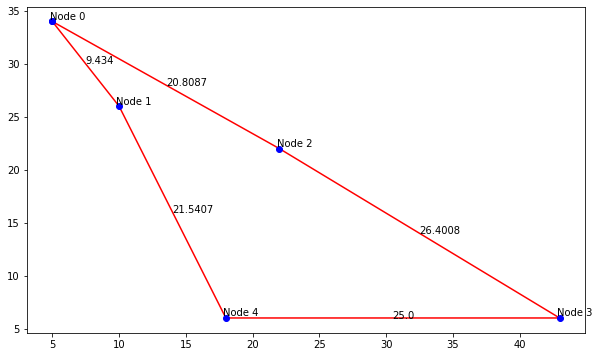

In [296]:
[best_route,best_cost] = simulation.brute_force()

print(f'A melhor rota por Força bruta foi {best_route} e o seu custo é {round(simulation.calculate_cost(best_route),3)} e tbm deve ser {best_cost}')

cost_texts = convex_combination_of_edges(best_route,xs,ys,0.5,node_number)

plot_vertices(best_route,xs,ys,node_number,'red',cost_text=cost_texts,cost_matrix=simulation.costs,save_fig=True,name_fig='Brute_force')
